In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from IPython.display import display

import pandas as pd
import numpy as np

import os
import gc
import feather

import matplotlib
import matplotlib.pyplot as plt

pd.set_option("max_colwidth", -1)
pd.set_option("max_columns", 500)
pd.set_option("max_rows", 500)

from tqdm import tqdm_notebook as tqdm

import pandas_profiling
# df.profile_report()
# Generating dataset profile
# pandas_profiling.ProfileReport(dataframe)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
plt.style.use('fivethirtyeight')
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14

In [6]:
train = pd.read_csv("../train_data.csv", index_col=None)
print(train.shape)
train.head()

(14446880, 6)


,patient_id,event_name,event_time,specialty,plan_type,patient_payment
0,patient_1,event_1,47,spec_1,plan_1,0.0
1,patient_4,event_1,727,spec_1,plan_2,0.0
2,patient_6,event_1,738,spec_1,plan_1,0.0
3,patient_7,event_1,923,spec_1,plan_1,0.0
4,patient_9,event_1,49,spec_1,plan_1,0.0


In [7]:
train_labels = pd.read_csv("../train_labels.csv")

train = pd.merge(train, train_labels, on='patient_id', how='left')

del train_labels
gc.collect()

15

In [8]:
train.head()

,patient_id,event_name,event_time,specialty,plan_type,patient_payment,outcome_flag
0,patient_1,event_1,47,spec_1,plan_1,0.0,0
1,patient_4,event_1,727,spec_1,plan_2,0.0,0
2,patient_6,event_1,738,spec_1,plan_1,0.0,0
3,patient_7,event_1,923,spec_1,plan_1,0.0,0
4,patient_9,event_1,49,spec_1,plan_1,0.0,0


In [9]:
test = pd.read_csv("../test_data.csv", index_col=None)
print(test.shape)
test.head()

(6256395, 6)


,patient_id,event_name,event_time,specialty,plan_type,patient_payment
0,patient_2,event_1,164,spec_1,plan_2,0.0
1,patient_3,event_1,420,spec_1,plan_2,0.0
2,patient_5,event_1,623,spec_1,plan_2,0.0
3,patient_8,event_1,162,spec_1,plan_1,0.0
4,patient_14,event_1,243,spec_1,plan_2,0.0


In [10]:
target = 'outcome_flag'

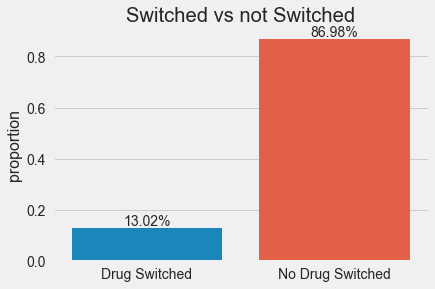

In [12]:
import seaborn as sns
mean_val = (train[target] == 1).mean()
ax = sns.barplot(['Drug Switched', 'No Drug Switched'],[mean_val, 1-mean_val])
ax.set(ylabel='proportion', title='Switched vs not Switched')
for p, uniq in zip(ax.patches, [mean_val, 1-mean_val]):
    height = p.get_height()
    ax.text(p.get_x()+p.get_width()/2., height+0.01, '{}%'.format(round(uniq * 100, 2)), ha="center")

In [13]:
train.profile_report()

# Training data Observation

* We have ~14.5 millions records and ~16k patients
* 50% records are duplicate rows (this looks high number)
* No missing values
* 6 independent variables (2 numeric and 4 categorical)
* Patient_payment is skewed and 80% zero values
* 13% people with drug switch (target variable)
* negative value in patient payment. Might be discounts.

In [14]:
test.profile_report()

# Test data Observation

* We have ~6 millions records and ~7k patients
* 50% records are duplicate rows (this looks high number)
* No missing values
* 6 independent variables (2 numeric and 4 categorical)
* Patient_payment is skewed and 80% zero values

In [15]:
from pandas_summary import DataFrameSummary
dfs = DataFrameSummary(train)
# dfs.columns_stats.T.sort_values(by='missing_perc')
dfs.summary().T

/Users/abdulqam/.conda/envs/python3/lib/python3.6/site-packages/pandas_summary/__init__.py:91: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  stats.ix[columns, 'types'] = ctype


,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
patient_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14446880,16683,0,0%,categorical
event_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14446880,520,0,0%,categorical
event_time,1.44469e+07,497.691,312.708,1,223,477,762,1080,14446880,1080,0,0%,numeric
specialty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14446880,229,0,0%,categorical
plan_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14446880,6,0,0%,categorical
patient_payment,1.44469e+07,7.29958,60.1839,-150,0,0,0,82959.3,14446880,46485,0,0%,numeric
outcome_flag,1.44469e+07,0.13023,0.336556,0,0,0,0,1,14446880,2,0,0%,bool


In [16]:
from pandas_summary import DataFrameSummary
dfs = DataFrameSummary(test)
# dfs.columns_stats.T.sort_values(by='missing_perc')
dfs.summary().T

,count,mean,std,min,25%,50%,75%,max,counts,uniques,missing,missing_perc,types
patient_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6256395,7148,0,0%,categorical
event_name,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6256395,520,0,0%,categorical
event_time,6.2564e+06,501.063,312.717,1,226,480,764,1080,6256395,1080,0,0%,numeric
specialty,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6256395,206,0,0%,categorical
plan_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6256395,6,0,0%,categorical
patient_payment,6.2564e+06,7.09704,68.3365,-61.95,0,0,0,39748.8,6256395,28517,0,0%,numeric


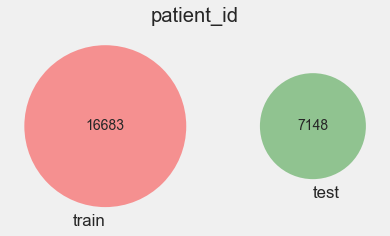

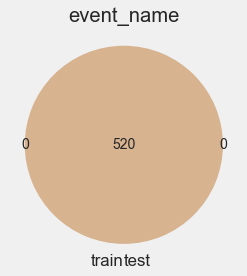

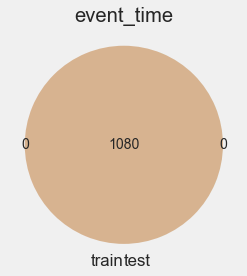

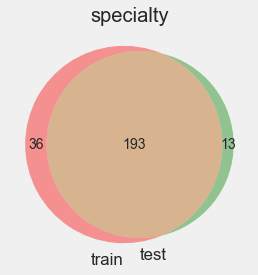

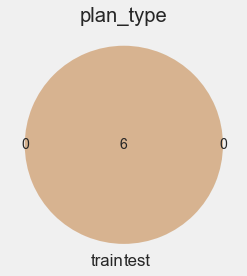

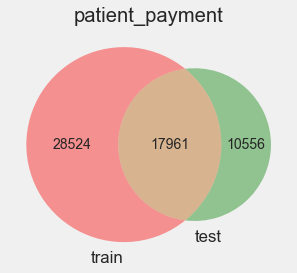

In [17]:
from matplotlib_venn import venn2
for feature in ['patient_id', 'event_name', 'event_time', 'specialty', 'plan_type',
       'patient_payment']:
#     print(feature)
    venn2([set(train[feature].values), set(test[feature].values)], set_labels = ('train', 'test'))
    plt.title(feature)
    plt.show()

In [18]:
train.head()

,patient_id,event_name,event_time,specialty,plan_type,patient_payment,outcome_flag
0,patient_1,event_1,47,spec_1,plan_1,0.0,0
1,patient_4,event_1,727,spec_1,plan_2,0.0,0
2,patient_6,event_1,738,spec_1,plan_1,0.0,0
3,patient_7,event_1,923,spec_1,plan_1,0.0,0
4,patient_9,event_1,49,spec_1,plan_1,0.0,0


In [19]:
test.head()

,patient_id,event_name,event_time,specialty,plan_type,patient_payment
0,patient_2,event_1,164,spec_1,plan_2,0.0
1,patient_3,event_1,420,spec_1,plan_2,0.0
2,patient_5,event_1,623,spec_1,plan_2,0.0
3,patient_8,event_1,162,spec_1,plan_1,0.0
4,patient_14,event_1,243,spec_1,plan_2,0.0


# Baseline Model

In [20]:
valid_set = train.patient_id.unique()[:len(test.patient_id.unique())]; len(valid_set)

7148

In [21]:
def split_vals(x, valid_set):
    return x[~x['patient_id'].isin(valid_set)].copy(), x[x['patient_id'].isin(valid_set)].copy()

In [22]:
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder

In [23]:
train.columns

Index(['patient_id', 'event_name', 'event_time', 'specialty', 'plan_type',
       'patient_payment', 'outcome_flag'],
      dtype='object')

In [24]:
_predictors = ['event_name', 'event_time', 'specialty', 'plan_type', 'patient_payment']
drop_cols = ['patient_id']

In [ ]:
from sklearn.metrics import roc_auc_score

def print_score(m):
    res = [roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), 
           roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1]),
           m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import Imputer, StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline

def _make_new_feature(data, name, features, weights):
    data[name] = 0
    for col, w in zip(features, weights):
        data[name] += data[col] * w
            
def get_clf_pipeline(): 
    #clf = LogisticRegression(class_weight='balanced')
    steps = [#('Impute', Imputer(strategy='median')),
             ('OHE', OneHotEncoder(sparse=False)),
             ('scaler', StandardScaler())]
             #('clf', clf)]
    return Pipeline(steps)

X_train, X_valid = split_vals(train, valid_set)
# X_test = test.copy()

y_train = X_train[target]
y_valid = X_valid[target]
X_train = X_train.drop([target]+drop_cols, axis=1)
X_valid = X_valid.drop([target]+drop_cols, axis=1)

pipeline = get_clf_pipeline()
X_train = pipeline.fit_transform(X_train)
X_valid = pipeline.transform(X_valid)

# clf = LogisticRegressionCV(class_weight='balanced')
# clf.fit(X_train, y_train)
# print_score(clf)
# print(pd.Series(clf.coef_[0], index=col_name).sort_values())